In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:

def calc_step(self, d):
    return np.sqrt(4 * d * 2)

def convert_d_from_nm2_ns_to_cm2_s(d: float):
    return d * 1e-14 / 1e-9

def convert_d_from_cm2_s_to_nm2_ns(d: float):
    return d * 1e-9 / 1e-14

def calc_d_from_step(step):
        """calculates the d value based on the step nm distance"""
        return (step**2) / (4 * 2)


def calc_step_rads(d):
    return np.sqrt(2 * d * 2)


def convert_d_from_rads2_s_to_rads2_ns(d: float):
    """converts time scale from s to ns"""
    return d * 1e-9

def convert_d_from_rads2_ns_to_rads2_s(d: float):
    """converts time scale from s to ns"""
    return d / 1e-9

def calc_rot_d_from_step(step):
    """calculate the d value for rotation based on the rotation mean in radians
    Rotation diffusion coefficient: D = rad^2 / (2*t)
    """
    return (step**2) / (2 * 2)

In [9]:
%matplotlib inline

file_str = "src\\grana_model\\res\log\\01072022_displacement_data.csv"

filename = f"{pathlib.Path.cwd()}/{file_str}"

if os.path.exists(filename):
    df = pd.read_csv(filename)
else:
    print(f"{filename} does not exist")

df["displacement_sq"] = df["displacement"]**2
df["rotation_sq"] = df["rot_from_origin"]**2


In [11]:
df.head()

,time,displacement,rot_from_origin,mass,rotation_scalar,diffusion_scalar,x,y,theta,displacement_sq,rotation_sq
0,0.0,0.000,-3.417132,1000.0,0.001785,1220.0,200.131083,295.020177,2.139292,0.000000,11.676792
1,2.0,0.011,-3.416959,1000.0,0.001785,1220.0,200.139894,295.013698,2.139465,0.000121,11.675607
2,4.0,0.017,-3.418452,1000.0,0.001785,1220.0,200.148089,295.017132,2.137973,0.000289,11.685811
3,6.0,0.023,-3.413262,1000.0,0.001785,1220.0,200.153368,295.025093,2.143163,0.000529,11.650355
4,8.0,0.045,-3.409736,1000.0,0.001785,1220.0,200.173892,295.033322,2.146689,0.002025,11.626298


In [42]:
dflm = df.drop(columns=["rot_from_origin", "displacement", "mass", "rotation_scalar", "diffusion_scalar", "x", "y", "theta", "rotation_sq"]).copy()
dflm = dflm.dropna()
dflm

,time,displacement_sq
0,0.0,0.000000
1,2.0,0.000121
2,4.0,0.000289
3,6.0,0.000529
4,8.0,0.002025
...,...,...
9999995,1990.0,21.687649
9999996,1992.0,21.399876
9999997,1994.0,21.114025
9999998,1996.0,20.912329


In [40]:
# linear regression on data
y = dflm[["displacement_sq"]]
x = dflm[["time"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=26)


slr = LinearRegression()
slr.fit(x_train, y_train)

print(f"Intercept: {slr.intercept_}, coef: {slr.coef_}")

Intercept: [-3.42339188], coef: [[0.04771214]]


In [41]:
# predict values
yhat = slr.predict(x_test).flatten()
print(yhat.shape)
slr_diff = pd.DataFrame({"y_test": y_test["displacement_sq"], "yhat": yhat}, index=[i for i in range(yhat.shape[0])])
slr_diff

(3000000,)


,y_test,yhat
0,NaN,80.072849
1,NaN,53.067779
2,NaN,31.883590
3,0.000529,11.939916
4,NaN,20.718950
...,...,...
2999995,129.072321,33.696651
2999996,127.938721,37.227349
2999997,NaN,77.305545
2999998,NaN,65.186662


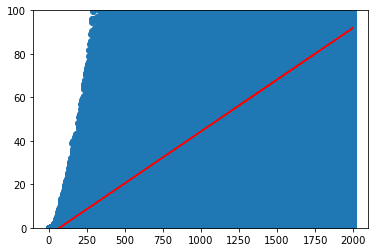

In [45]:
plt.scatter(x_test, y_test)
plt.plot(x_test, yhat, 'Red')
plt.ylim([0, 100])
plt.show()

meas D = 2.85e-04
exp D = 1.88e-04
step_nm = 0.04771 nm


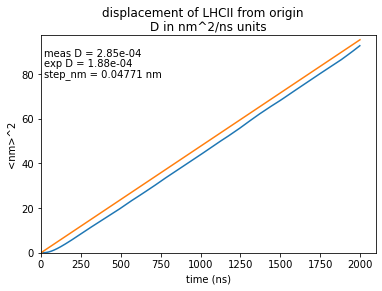

In [4]:
selection = df[['time', 'displacement_sq']].groupby("time").mean()

lm_time = np.arange(0, 2000)

# line_y = np.linspace(0, np.max(selection["displacement_sq"]), 2000)

lm = np.poly1d(np.polyfit(df["time"], df["displacement_sq"], 1))
   
def predict_line(m, b, n):
    return [m*i + b for i in range(n)]

line_y = predict_line(m=lm.coef[0], b=0, n=len(lm_time))   

d = calc_d_from_step(step=lm.coef[0])
d_text = f"meas D = {d:.2e}"
exp_text = f"exp D = {convert_d_from_cm2_s_to_nm2_ns(d=1.88e-9):.2e}" # 1.88e-9 cm2/s
    
step_text = f"step_nm = {round(lm.coef[0], 5)} nm"

print(d_text)
print(exp_text)
print(step_text)

# plot the displacement_sq against the fit

plt.suptitle("displacement of LHCII from origin")
plt.title("D in nm^2/ns units")
plt.xlabel("time (ns)")
plt.ylabel("<nm>^2")
plt.xlim(0, np.max(df["time"]) * 1.05)
plt.ylim(0, np.max(selection["displacement_sq"]) * 1.05)
plt.annotate(text=d_text, xy=(20, np.max(selection["displacement_sq"]) * 0.95))
plt.annotate(text=step_text, xy=(20, np.max(selection["displacement_sq"]) * 0.85))
plt.annotate(text=exp_text, xy=(20, np.max(selection["displacement_sq"]) * 0.90))
plt.plot(selection["displacement_sq"])
plt.plot(lm_time, line_y)

meas D = 2.85e-04
exp D = 1.88e-04
step_nm = 0.04771 nm


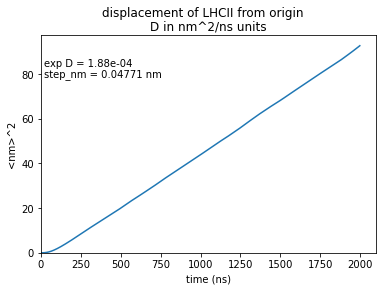

In [7]:
selection = df[['time', 'displacement_sq']].groupby("time").mean()

lm_time = np.arange(0, 2000)

# line_y = np.linspace(0, np.max(selection["displacement_sq"]), 2000)

lm = np.poly1d(np.polyfit(df["time"], df["displacement_sq"], 1))
   
def predict_line(m, b, n):
    return [m*i + b for i in range(n)]

line_y = predict_line(m=lm.coef[0], b=0, n=len(lm_time))   

d = calc_d_from_step(step=lm.coef[0])
d_text = f"meas D = {d:.2e}"
exp_text = f"exp D = {convert_d_from_cm2_s_to_nm2_ns(d=1.88e-9):.2e}" # 1.88e-9 cm2/s
    
step_text = f"step_nm = {round(lm.coef[0], 5)} nm"

print(d_text)
print(exp_text)
print(step_text)

# plot the displacement_sq against the fit

plt.suptitle("displacement of LHCII from origin")
plt.title("D in nm^2/ns units")
plt.xlabel("time (ns)")
plt.ylabel("<nm>^2")
plt.xlim(0, np.max(df["time"]) * 1.05)
plt.ylim(0, np.max(selection["displacement_sq"]) * 1.05)
# plt.annotate(text=d_text, xy=(20, np.max(selection["displacement_sq"]) * 0.95))
plt.annotate(text=step_text, xy=(20, np.max(selection["displacement_sq"]) * 0.85))
plt.annotate(text=exp_text, xy=(20, np.max(selection["displacement_sq"]) * 0.90))
plt.plot(selection["displacement_sq"])
# plt.plot(lm_time, line_y)

meas D = 4.33e-11
exp D = 2.00e-06
step_rads = 1e-05 rads/ns


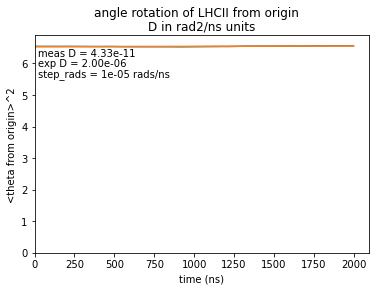

In [24]:
selection = df[['time', 'rotation_sq']].groupby("time").mean()

lm_time = np.arange(0, 2000)

line_y = np.linspace(0, np.max(selection["rotation_sq"]), 2000)

lm = np.poly1d(np.polyfit(df["time"], df["rotation_sq"], 1))
   
d = calc_rot_d_from_step(step=lm.coef[0])
d_text = f"meas D = {d:.2e}"
exp_text = f"exp D = {convert_d_from_rads2_s_to_rads2_ns(d=2e3):.2e}" # 2e3 rads2/s
    
step_text = f"step_rads = {round(lm.coef[0], 5)} rads/ns"

print(d_text)
print(exp_text)
print(step_text)

# plot the displacement_sq against the fit

plt.suptitle("angle rotation of LHCII from origin")
plt.title("D in rad2/ns units")
plt.xlabel("time (ns)")
plt.ylabel("<theta from origin>^2")
plt.xlim(0, np.max(df["time"]) * 1.05)
plt.ylim(0, np.max(selection["rotation_sq"]) * 1.05)
plt.annotate(text=d_text, xy=(20, np.max(selection["rotation_sq"]) * 0.95))
plt.annotate(text=step_text, xy=(20, np.max(selection["rotation_sq"]) * 0.85))
plt.annotate(text=exp_text, xy=(20, np.max(selection["rotation_sq"]) * 0.90))
plt.plot(selection["rotation_sq"])
plt.plot(lm(lm_time))



In [ ]:
d0 = 0.00018 # d0 in nm2/ns

d1 = convert_d_from_nm2_ns_to_cm2_s(d0) # convert to cm2/s units

d2 = convert_d_from_cm2_s_to_nm2_ns(d1) # convert the cm2/s units back to nm2/ns units

print(f"d0==d2 is {d0 == d2}")

step_nm = calc_step(d0)

step_cm = calc_step(d1)

print(f"d0: {d0}, d1: {d1}, d2: {d2}")

print(f"nm/ns step: {step_nm}")

print(f"cm/s step: {step_cm}")


In [ ]:
df_d = pd.read_csv("C:\\projects\\grana_model\\src\\grana_model\\res\log\\d_calc.csv")
print(df_d.mean())

df_d.hist()

In [ ]:
from src.grana_model.dcalibrator import DCalibrator

structure_dict={
                "LHCII": {
                    "d": 1.8e-9,  # 1.8e-9 in cm2/s
                    "d_rot": 2e13,  # 2 x 10^3  rad^2 s^(-1)
                    "simulation_limit": 100000,
                    "distance_scalar": "well",
                    "diffusion_scalar": 1220.0,  # average over 250 steps, gave us this number for keeping step_nm equal to calculated step
                    "distance_threshold": 50.0,
                    "mass": 1000.0,
                    "mass_scalar": 1.0,
                    "rotation_scalar": 180.0,  # average over 250 steps, gives us <d_rot> of 2.00e13
                    "time_per_step": 2,  # in ns
                    "average_step_over": 250,
                    "calibrate_rot_d": False,
                    "calibrate_diff_d": False,
                }
}

dcal = DCalibrator(structure_dict["LHCII"])

d_ns = dcal.convert_d_from_rads2_s_to_rads2_ns(d=2e13)
print(d_ns)